In [1]:
import plot
from shap.maskers import Independent
from sklearn.utils import resample, shuffle
import shap
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
%matplotlib inline
shap.initjs()

In [2]:
with open('classifiers.pickle', 'rb') as f:
    clf_a, clf_b = pickle.load(f)
with open('predictions.pickle', 'rb') as f:
    X, feature_names, n_features, n_samples, indices, pred_a, pred_b, proba_a, proba_b, log_proba_a, log_proba_b, log_odds_a, log_odds_b = pickle.load(f)

In [3]:
try:
    with open(f'shapvalues.soa.log_odds.pickle', 'rb') as f:
        shap_values_a, shap_values_b, shap_values_a_vs_b, is_finite, is_normal, feature_order = pickle.load(f)
        print('Loaded cached shap values')
except FileNotFoundError:
    print('No cached shap values found')

Loaded cached shap values


## Generate Explanations

Now we define the functions to be explained:

In [78]:
log_proba_to_log_odds = lambda log_proba: log_proba[:, 1] - log_proba[:, 0]
predict_log_odds_a = lambda X: log_proba_to_log_odds(clf_a.predict_log_proba(X))
predict_log_odds_b = lambda X: log_proba_to_log_odds(clf_b.predict_log_proba(X))

And now we calculate SHAP values for each function:

In [97]:
%%time

background_data = X
def explain(predict):
    masker = Independent(data=background_data)
    explainer = shap.Explainer(predict, masker, feature_names=feature_names)
    shap_values = explainer(X)
    return shap_values

shap_values_a = explain(predict_log_odds_a)
shap_values_b = explain(predict_log_odds_b)

shap_values_a_vs_b = shap_values_b - shap_values_a
shap_values_a_vs_b.data = shap_values_a.data

is_finite = np.all(np.isfinite(shap_values_a.values), axis=1) & np.all(np.isfinite(shap_values_b.values), axis=1)
is_normal = is_finite
feature_order = np.flip(shap_values_a_vs_b[is_normal].abs.mean(axis=0).values.argsort())

with open(f'shapvalues.soa.log_odds.pickle', 'wb') as f:
    pickle.dump((shap_values_a, shap_values_b, shap_values_a_vs_b, is_finite, is_normal, feature_order), f, pickle.HIGHEST_PROTOCOL)

CPU times: user 1.99 s, sys: 23.5 ms, total: 2.01 s
Wall time: 2.18 s


## Analyze

In [98]:
print(f'non-finite SHAP-values: {np.sum(~is_finite)}')
print(f'total SHAP-values: {len(is_normal)}')

non-finite SHAP-values: 0
total SHAP-values: 959


### Feature Importance

We estimate it with the mean absolute SHAP value (which is the default for this plot) and will also sort features subsequently in this order

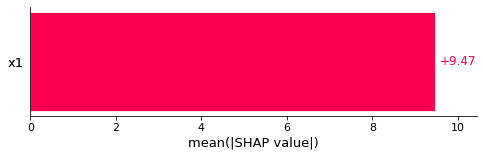

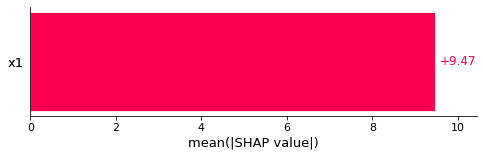

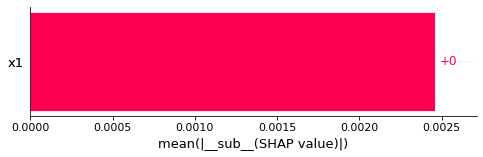

In [100]:
shap.plots.bar(shap_values_a[is_normal], order=feature_order, max_display=n_features)
shap.plots.bar(shap_values_b[is_normal], order=feature_order, max_display=n_features)
shap.plots.bar(shap_values_a_vs_b[is_normal], order=feature_order, max_display=n_features)

### SHAP Value Distribution

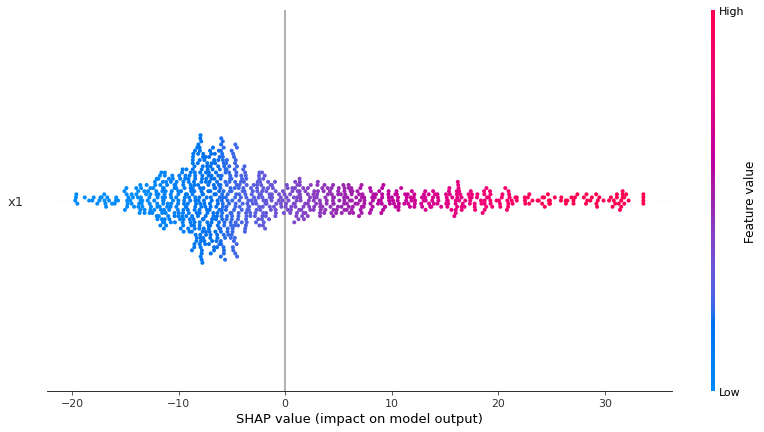

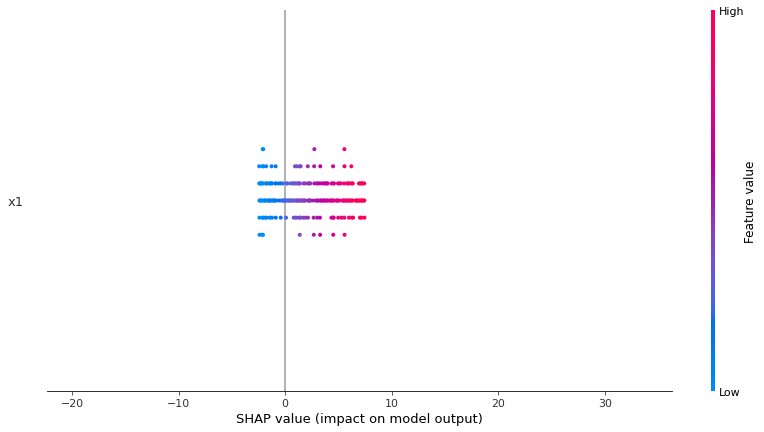

In [4]:
shap.plots.beeswarm(shap_values_a[is_normal], order=feature_order, max_display=n_features, plot_size=(14, 7), show=False)
xlim = plt.xlim()
plt.show()
shap.plots.beeswarm(shap_values_a[is_normal & (pred_a != pred_b)], order=feature_order, max_display=n_features, plot_size=(14, 7), show=False)
plt.xlim(xlim)
plt.show()

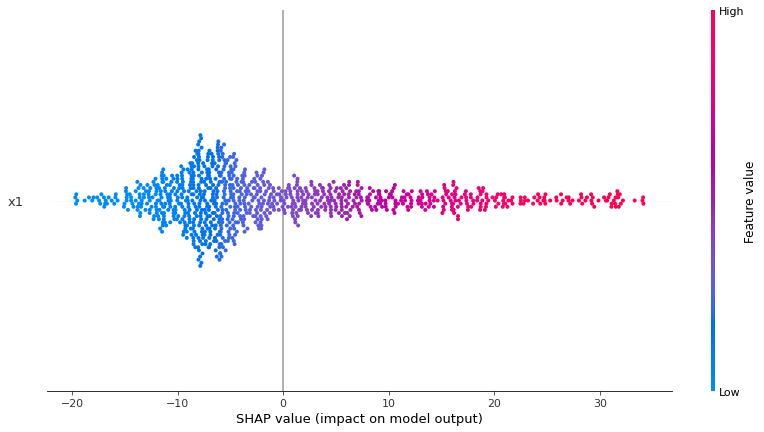

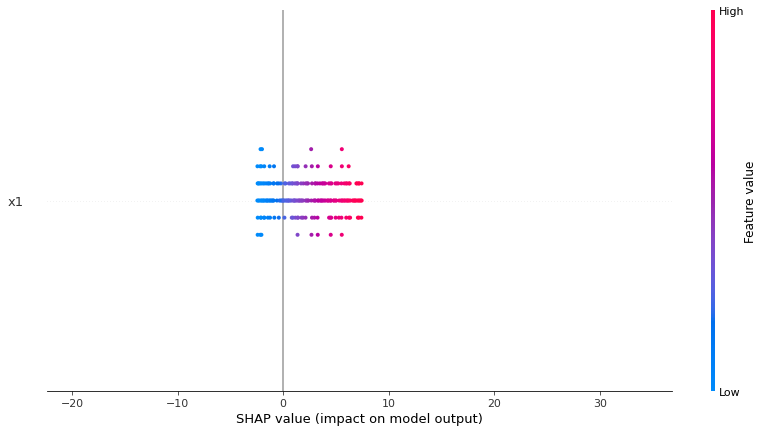

In [5]:
shap.plots.beeswarm(shap_values_b[is_normal], order=feature_order, max_display=n_features, plot_size=(14, 7), show=False)
xlim = plt.xlim()
plt.show()
shap.plots.beeswarm(shap_values_b[is_normal & (pred_a != pred_b)], order=feature_order, max_display=n_features, plot_size=(14, 7), show=False)
plt.xlim(xlim)
plt.show()

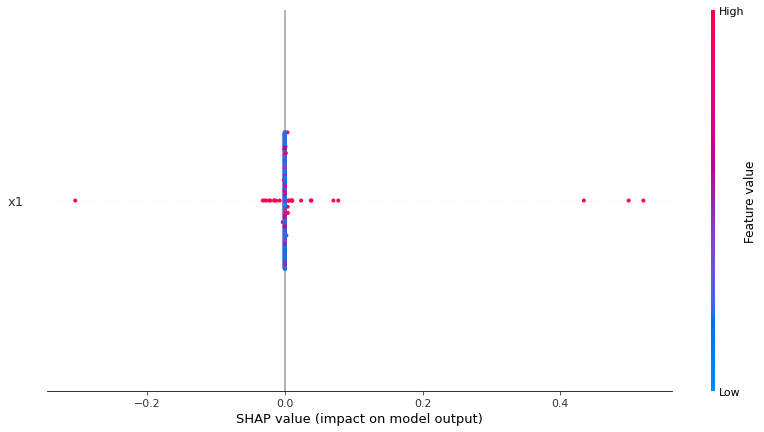

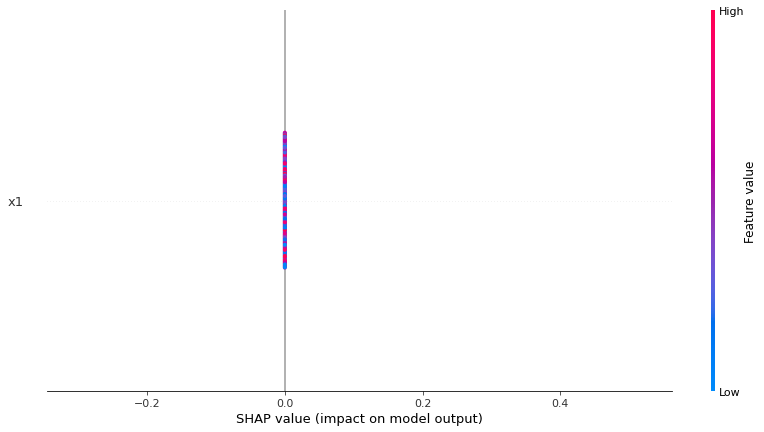

In [6]:
shap.plots.beeswarm(shap_values_a_vs_b[is_normal], order=feature_order, max_display=n_features, plot_size=(14, 7), show=False)
xlim = plt.xlim()
plt.show()
shap.plots.beeswarm(shap_values_a_vs_b[is_normal & (pred_a != pred_b)], order=feature_order, max_display=n_features, plot_size=(14, 7), show=False)
plt.xlim(xlim)
plt.show()

### Features' Partial Dependence Plots

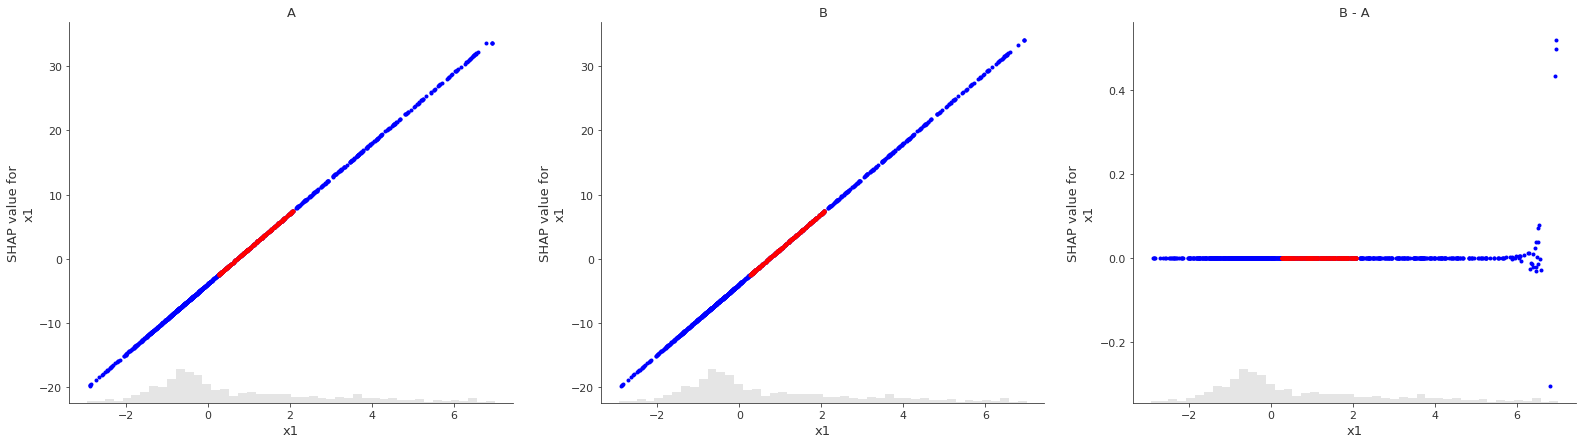

In [104]:
n_columns = 3
n_rows = n_features
fig = plt.figure(figsize=(9*n_columns, 7*n_rows))
i = 1
for feature in feature_names:
    ax1 = fig.add_subplot(n_rows, n_columns, i)
    ax2 = fig.add_subplot(n_rows, n_columns, i+1, sharey=ax1)
    ax3 = fig.add_subplot(n_rows, n_columns, i+2, sharey=None)
    shap.plots.scatter(shap_values_a[is_normal, feature], title='A', ax=ax1, color='blue', show=False)
    shap.plots.scatter(shap_values_a[is_normal & (pred_a != pred_b), feature], title='A', ax=ax1, color='red', hist=False, show=False)
    shap.plots.scatter(shap_values_b[is_normal, feature], title='B', ax=ax2, color='blue', show=False)
    shap.plots.scatter(shap_values_b[is_normal & (pred_a != pred_b), feature], title='B', ax=ax2, color='red', hist=False, show=False)
    shap.plots.scatter(shap_values_a_vs_b[is_normal, feature], title='B - A', ax=ax3, color='blue', show=False)
    shap.plots.scatter(shap_values_a_vs_b[is_normal & (pred_a != pred_b), feature], title='B - A', ax=ax3, color='red', hist=False, show=False)
    i += n_columns
plt.show()

### Stacked SHAP Explanations, Clustered by Similarity

In [105]:
mask = is_normal & (pred_a != pred_b)
order = plot.shap_force(shap_values_a_vs_b[mask], 'A vs. B')
plot.shap_force(shap_values_a[mask], 'A', ordering=order)
plot.shap_force(shap_values_b[mask], 'B', ordering=order);

In [106]:
idx_pred_eq = resample(indices[is_normal & (pred_a == pred_b)], n_samples=100, replace=False, random_state=3)
order = plot.shap_force(shap_values_a_vs_b[idx_pred_eq], 'A vs. B')
plot.shap_force(shap_values_a[idx_pred_eq], 'A', ordering=order)
plot.shap_force(shap_values_b[idx_pred_eq], 'B', ordering=order);

### Hierarchically Clustered SHAP Values

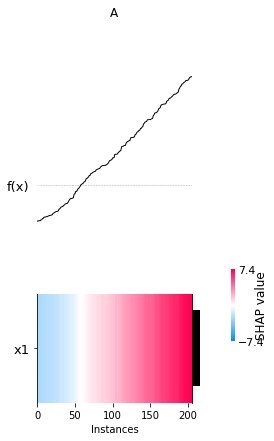

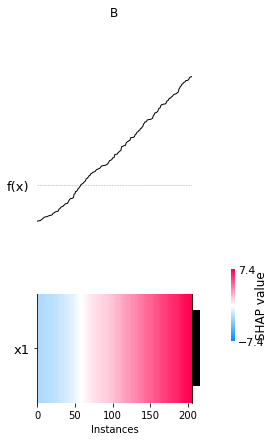

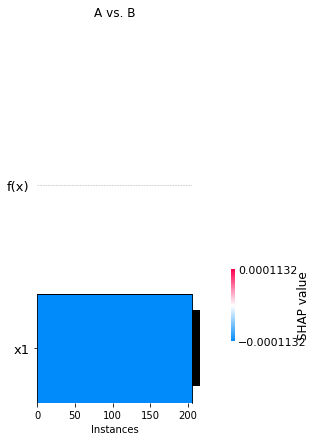

In [107]:
mask = is_normal & (pred_a != pred_b)
plot.shap_heatmap(shap_values_a[mask], 'A', feature_order)
plot.shap_heatmap(shap_values_b[mask], 'B', feature_order)
plot.shap_heatmap(shap_values_a_vs_b[mask], 'A vs. B', feature_order)

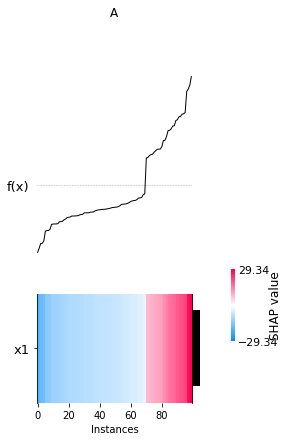

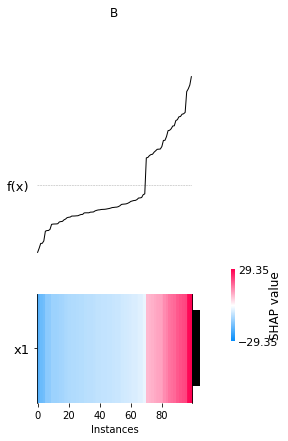

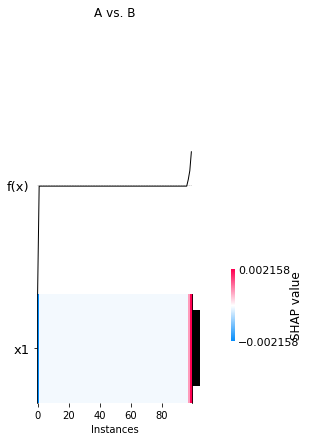

In [108]:
mask = is_normal & (pred_a == pred_b)
shap_values_a_subset, shap_values_b_subset, shap_values_a_vs_b_subset = \
    shuffle(shap_values_a[mask], shap_values_b[mask], shap_values_a_vs_b[mask], random_state=0, n_samples=100)
plot.shap_heatmap(shap_values_a_subset, 'A', feature_order)
plot.shap_heatmap(shap_values_b_subset, 'B', feature_order)
plot.shap_heatmap(shap_values_a_vs_b_subset, 'A vs. B', feature_order)

### Unusual instances

#### Non-finite SHAP-values

In [110]:
idx_nonfinite = np.where(~is_finite)[0]

In [111]:
pd.DataFrame(X[idx_nonfinite, :], index=idx_nonfinite, columns=feature_names)

,x1


In [112]:
pd.DataFrame(shap_values_a[idx_nonfinite].values, index=idx_nonfinite, columns=feature_names)

,x1


In [113]:
pd.DataFrame(shap_values_b[idx_nonfinite].values, index=idx_nonfinite, columns=feature_names)

,x1
